In [1]:
from pydrake.all import (
    MultibodyPlantConfig,
    Meshcat,
    StartMeshcat,
    DiagramBuilder,
    AddMultibodyPlant,
    Parser,
    LoadModelDirectives,
    ModelDirectives,
    ProcessModelDirectives,
    Diagram,
    Context,
    AddDefaultVisualization,
    RigidTransform,
    Quaternion,
    MultibodyPlant,
    JacobianWrtVariable,
    MathematicalProgram,
    eq,
    Solve
)
import numpy as np
import matplotlib.pyplot as plt

In [2]:
meshcat: Meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


## Example Setup for Spinner

In [3]:
# Example Setup
meshcat.SetCameraPose(np.array([1.0,-0.5,2.0]), np.array([0.8, -0.5, 0.0]) )

config = MultibodyPlantConfig()
config.time_step = 0.001
config.penetration_allowance = 0.001
config.contact_model = "hydroelastic_with_fallback"
config.contact_surface_representation = "polygon"
config.discrete_contact_approximation = "tamsi"

builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlant(config, builder)
parser = Parser(plant, scene_graph)
parser.package_map().AddPackageXml('../package.xml')

directive_file = "../config/spinner.yaml"
directives: ModelDirectives = LoadModelDirectives(directive_file)
models = ProcessModelDirectives(directives, plant, parser)
plant.Finalize()

AddDefaultVisualization(builder, meshcat)

diagram: Diagram = builder.Build()
context: Context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(context)
diagram.ForcedPublish(context)

In [4]:
context.SetTime(0.0)
plant.SetPositions(plant_context, [0.2, 0.2, 1.0])
body_rt = RigidTransform(Quaternion(1.0,0.0,0.0,0.0), [0.0, 0.0, 0.25])
diagram.ForcedPublish(context)

Playing around with this setup, you'll notice that the first two positions in the plant are related to the two revolute jointed arm. The arm is a fixed base (meaning it's welded to the floor at the origin).

The ball is also a fixed base with only rotated being possible. This is planned in SE(2) as a small test for contact implicit MPC.

# Contact Implicit MPC Modelling

We want to spin the "spinner" ball to a specified angle in yaw direction. We model this as a trajectury optimization problem where we make a quadratic cost and dynamical equality constraints. 

## Contact Implicit formulation

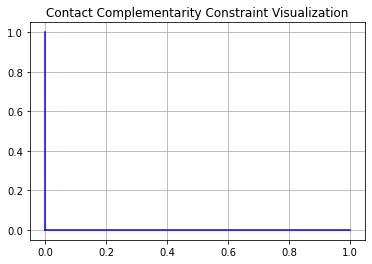

In [5]:
#fn = normal force
fn_on = np.linspace(0.0,1.0,20)
fn_off = np.zeros(20)

# phi = signed distance between end-effector and object
phi_on = np.linspace(0.0,1.0,20)
phi_off = np.zeros(20)

plt.plot(phi_on, fn_off, c='b')
plt.plot(phi_off, fn_on, c='b')
plt.grid()
plt.title("Contact Complementarity Constraint Visualization")
plt.show()

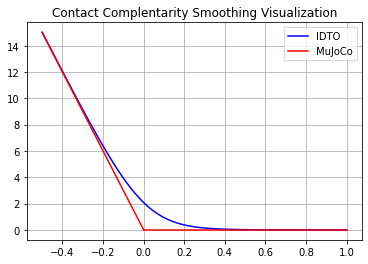

In [6]:
sigma = 0.1 #smoothing parameter
kspring = 30.0 #spring stiffness
phis = np.linspace(-0.5, 1.0, 100)
fns  = sigma * kspring * np.log(1 + np.exp(-phis/sigma))

phis_nonpenetrate = np.linspace(0.0, 1.0, 100)
fns_nonpenetrate = np.zeros(100)

phis_penetrate = np.linspace(-0.5, 0.0, 100)
fns_penetrate = -kspring*phis_penetrate

plt.plot(phis, fns, c='b', label='IDTO')
plt.plot(phis_nonpenetrate, fns_nonpenetrate, c='r', label='MuJoCo')
plt.plot(phis_penetrate, fns_penetrate, c='r')
plt.grid()
plt.title("Contact Complentarity Smoothing Visualization")
plt.legend()
plt.show()

## Dynamics Formulation

Using the spinning example, we get the manipulator equations and find the equations guiding the first-order Euler integration of said equations.

The manipulator equations are denoted as follows:
$$
M(q)\ddot q + C(q,\dot q)\dot q + \tau_g(q) = u + J^Tf
$$

In [7]:
# quickly setup a diagram
config = MultibodyPlantConfig()
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlant(config, builder)
plant: MultibodyPlant = plant
plant.mutable_gravity_field().set_gravity_vector([0, 0, 0]) # set gravity to zero

parser = Parser(plant, scene_graph)
parser.package_map().AddPackageXml('../package.xml')

directive_file = "../config/spinner.yaml"
directives: ModelDirectives = LoadModelDirectives(directive_file)
models = ProcessModelDirectives(directives, plant, parser)
plant.Finalize()
diagram: Diagram = builder.Build()

In [8]:
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(context)

# get manipulator equations, but only consider the 2R arm instead of the spinner ball
M = plant.CalcMassMatrix(plant_context)[:2,:2]
C = plant.CalcBiasTerm(plant_context)[:2]
tau_g = plant.CalcGravityGeneralizedForces(plant_context)[:2]
print("M = ", M)
print("C = ", C)
print("tau_g = ", tau_g)

M =  [[2.6678 0.8339]
 [0.8339 0.3339]]
C =  [0. 0.]
tau_g =  [-0. -0.]


To get the dynamical system from the manipulator equations, solve for $\ddot q$.
$$
\ddot q = M^{-1}(q)(u + J^Tf - C(q,\dot q)\dot q - \tau_g(q))
$$

Let state $x = \begin{bmatrix} q & v \end{bmatrix}^T$ such that.

$$
\dot x = f(x,u)
$$

$$
\dot x = 
\begin{bmatrix}
\dot q \\
M^{-1}(q)(u + J^Tf - C(q,\dot q)\dot q - \tau_g(q))
\end{bmatrix}
$$

Note that we are using v instead of $\dot q$. This is because a kinematic mapping is required such that we get the generalized velocities of the system. This is a formality. Most of the time $\dot q = v$, but we specify the relationship between the two as follows:
$$
\dot q = N(q)v
$$

In [9]:
q = np.array([0,0,0])
plant.SetPositions(plant_context, q)
#get arm position using forward kinematics
finger_pose = plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName("finger_two"))

N_q = plant.CalcJacobianSpatialVelocity(plant_context, with_respect_to=JacobianWrtVariable.kQDot,
                                        frame_B=plant.GetFrameByName("finger_two"),
                                        p_BoBp_B=[0,0,0],
                                        frame_A=plant.world_frame(),
                                        frame_E=plant.world_frame())
print("Forward Kinematics:")
print(finger_pose)
print("Kinematic Jacobian:")
print(np.around(N_q,3)) # top 3 rows are angular velocity, bottom 3 rows are positional velocity

Forward Kinematics:
RigidTransform(
  R=RotationMatrix([
    [1.0, 0.0, 0.0],
    [0.0, 4.8965888601467475e-12, -1.0],
    [0.0, 1.0, 4.8965888601467475e-12],
  ]),
  p=[0.0, -1.0, 4.8965888601467475e-12],
)
Kinematic Jacobian:
[[0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


To include our kinematic mapping in our manipulator equations, we do the following:
$$
M_x(q)\dot v + k(q,v) + \tau_g(q) = u + J^T f
$$
To relate this to the previous manipulator equation, we can expand on this expression:
$$
M(q)\dot v + C(q, N^{+}(q)\dot q)N^{+}(q)v + \tau_g(q) = u + J^T f
$$
So we can also say
$$
M_x(q) = M(q)
$$
$$
k(q,v) = C(q,N^{+}(q)\dot q)N^{+}(q)v
$$
$N^{+}(q)$ is the pseudo-inverse of $N(q)$

We can similarly get the dynamical system of our newly defined state:

$$
\dot x = 
\begin{bmatrix}
N^{+}(q)v \\
M_x(q)^{-1}(u + J^T f - k(q,v) - \tau_g(q))
\end{bmatrix}
$$

With this in mind, we discretize the dynamical system and formulate our optimization problem.

## Inverse Dynamics TrajOpt specifics
So in order to make this work for the IDTO paper, our equality constraints are actually the inverse dynamical of the system.

$$
a = \dot v
$$

$$
u = M_x(q)a + k(q,v) + \tau_g(q) - J^T f
$$

so we can replace all of our $v$ and $a$ terms with just $q$
$$
v_k(q) = N^{+}(q_k)\frac{q_k - q_{k-1}}{\delta t}
$$
$$
a_k(q) = \frac{v_{k+1} - v_k}{\delta t}
$$
This makes everything in the optimization in terms of $q$ and thus the only decision variable.

We setup our optimization as follows:

$$
\min_{q,u} \sum_{i=0}^N \| q_i - q_d \|_2^2 + \sum_{i=1}^N \| u_i \|_2^2 \\
s.t. \\
u_i = M_x(q_{i+1})a_i + k(q_{i+1},v_{i+1}) + \tau_g(q_{i+1}) - J^T f
$$

## MPC using no contact
Goal: go to a position using IDTO formulation but without contact

In [10]:
# quickly setup a diagram
config = MultibodyPlantConfig()
builder = DiagramBuilder()
plant_f, scene_graph = AddMultibodyPlant(config, builder)
plant_f: MultibodyPlant = plant_f
plant_f.mutable_gravity_field().set_gravity_vector([0, 0, 0]) # set gravity to zero

parser = Parser(plant_f, scene_graph)
parser.package_map().AddPackageXml('../package.xml')

directive_file = "../config/spinner.yaml"
directives: ModelDirectives = LoadModelDirectives(directive_file)
models = ProcessModelDirectives(directives, plant_f, parser)
plant_f.Finalize()
diagram: Diagram = builder.Build()
plant_ad: MultibodyPlant = plant_f.ToAutoDiffXd()

In [11]:
context_f = plant_f.CreateDefaultContext()
context_ad = plant_ad.CreateDefaultContext()

In [12]:
N_q

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.89658886e-12, 4.89658886e-12, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [13]:
des_q = np.array([0,0,0])
q0 = np.array([1.0,1.0,0])
qdot0 = np.array([0,0,0])
v0 = np.array([0,0,0])

prog = MathematicalProgram()

horizon = 50
dt = 0.1
qs = prog.NewContinuousVariables(rows=3, cols=horizon, name="qs")
us = prog.NewContinuousVariables(rows=2, cols=horizon-1, name="us")

# set initial conditions
prog.AddConstraint(eq(qs[:,0], q0))

# set vs and accels as lookups for qs
def calculate_vs(q):
    qs_var = q.reshape((3,horizon))
    if qs_var.dtype == float:
        plant = plant_f
        context = context_f
    else:
        plant = plant_ad
        context = context_ad
    vs = np.zeros((3,horizon),dtype=object)
    vs[:,0] = v0
    for i in range(1,horizon):
        plant.SetPositions(context, qs_var[:,i])
        vs[:,i] = plant_ad.MapQDotToVelocity(context_ad, qs_var[:,i] - qs_var[:,i-1])/dt # vdot = N_q * qdot
    return vs

def calculate_accels(vs_var):
    accels = np.zeros((3,horizon-1),dtype=object)
    for i in range(1,horizon-1):
        accels[:,i] = (vs_var[:,i+1] - vs_var[:,i])/dt
    return accels

def calculate_qdots(q):
    qs_var = q.reshape((3,horizon))
    qdots = np.zeros((3,horizon),dtype=object)
    qdots[:,0] = qdot0
    for i in range(1,horizon):
        qdots[:,i] = (qs_var[:,i] - qs_var[:,i-1])/dt
    return qdots

def custom_vel_cost(q):
    vs = calculate_vs(q)
    return sum(vs[0,:]**2) + sum(vs[1,:]**2)

prog.AddCost(sum(us[0,:]**2) + sum(us[1,:]**2)) # minimize control effort for 2R arms
prog.AddCost(100*(sum(qs[0,:]**2) + sum(qs[1,:]**2))) # minimize joint angles
prog.AddCost(custom_vel_cost, vars=qs.flatten()) # minimize cartesian finger velocities

def calculate_sdf(sphere_pos, sphere_radius, ee_pos):
    return np.linalg.norm(sphere_pos - ee_pos) - sphere_radius

def calculate_dissipation(vn, vd):
    term = vn/vd
    if term < 0:
        return 1 - term 
    elif 0 <= term < 2:
        return (vn/vd - 2)**2/4
    else:
        return 0

def calculate_tangential_component(mu, vt, vs, fn):
    return -mu * (vt/np.sqrt(vs ** 2 + np.linalg.norm(vt) ** 2)) * fn

def calculate_normal_force(sigma, k, sdf):
    c_sdf = sigma * k * np.log(1 + np.exp(-sdf/ sigma))
    d = None
    return d

# add inverse dynamics constraint

def custom_inverse_dynamics_eval(var):
    q,u = np.split(var, [3*horizon])
    qs_var = q.reshape((3,horizon))
    us_var = u.reshape((2,horizon-1))
    vs_var = calculate_vs(q)
    accels = calculate_accels(vs_var)
    taus = np.zeros((2,horizon-1),dtype=object)
    for i in range(horizon-1):
        plant_ad.SetPositions(context_ad, qs_var[:,i+1])
        plant_ad.SetVelocities(context_ad, vs_var[:,i+1])
        
        M = plant_ad.CalcMassMatrix(context_ad)
        C = plant_ad.CalcBiasTerm(context_ad)
        
        tau_g = plant_ad.CalcGravityGeneralizedForces(context_ad)
        tau = M @ accels[:,i] + C + tau_g
        taus[:,i] = tau[:2]
    return (taus - us_var).flatten()
prog.AddConstraint(custom_inverse_dynamics_eval, lb=np.zeros(2*(horizon-1)), ub=np.zeros(2*(horizon-1)), vars=np.concatenate((qs.flatten(),us.flatten())))

In [14]:
result = Solve(prog)

print("Success? ", result.is_success())
print("Optimal cost: ", result.get_optimal_cost())
qs_sol = result.GetSolution(qs)

Success?  True
Optimal cost:  781.5149031999337


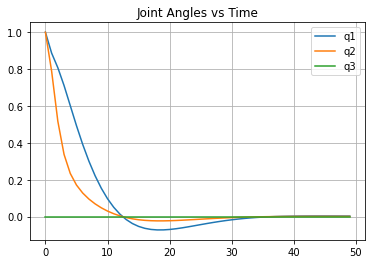

In [15]:
# plot solution
plt.plot(qs_sol[0,:], label='q1')
plt.plot(qs_sol[1,:], label='q2')
plt.plot(qs_sol[2,:], label='q3')
plt.grid()
plt.legend()
plt.title("Joint Angles vs Time")
plt.show()